<a href="https://colab.research.google.com/github/causallycausal/fastai/blob/dev/Projects/02_pizza_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook 
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
# Search key using duck duck go search engine.
# current fastai version is broken 
def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

# Goal 

Our goal with this project is to design an application that will classify three different types of pizza. The three categories will be cheese, pepperoni, and Hawaiian (ham and pineapple) pizza. In this notebook, we will gather the data, build the model, and  export the weights of the trained model to be used in a fun webapp. I will link to the webapp here after I have completed this project. 

# Gather Images of Pizza



In [5]:
pizza_types = ["cheese", "pepperoni", "Hawaiian"]
path = Path('pizzas')

In [6]:
if not path.exists():
  path.mkdir()
  for pizza in pizza_types: 
    dest = (path/pizza)
    dest.mkdir(exist_ok = True)
    results = search_images_ddg(f'{pizza} pizza')
    download_images(dest, urls=results)

In [7]:
image_paths = get_image_files(path)
image_paths

(#507) [Path('pizzas/cheese/00000177.jpg'),Path('pizzas/cheese/00000015.jpg'),Path('pizzas/cheese/00000063.jpg'),Path('pizzas/cheese/00000036.jpg'),Path('pizzas/cheese/00000058.jpg'),Path('pizzas/cheese/00000123.jpg'),Path('pizzas/cheese/00000071.jpg'),Path('pizzas/cheese/00000109.jpg'),Path('pizzas/cheese/00000079.jpg'),Path('pizzas/cheese/00000117.jpg')...]

# Verify our Images 

In [8]:
# Check if we can open our images 
failed = verify_images(image_paths)
failed

(#4) [Path('pizzas/cheese/00000095.jpeg'),Path('pizzas/cheese/00000007.jpg'),Path('pizzas/cheese/00000190.png'),Path('pizzas/Hawaiian/00000000.jpg')]

In [23]:
??verify_images

In [9]:
# Remove all images that we can't open 
failed.map(Path.unlink);

In [29]:
"""
Try to reproduce: usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
"""
extensions = []
for img in image_paths: 
  if img.suffix not in extensions: 
    extensions.append(img.suffix)
len(extensions), extensions

(5, ['.jpg', '.png', '.JPG', '.jpeg', '.gif'])

# Set up DataLoader 

In [10]:
pizzas = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Type of (input, labels)
    get_items=get_image_files, # function used to get image data
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # function to split images into valid/test sets
    get_y=parent_label, # tells us that our labels will come from the parent directory 
    item_tfms=Resize(128)) # resize images to 128x128


In [11]:
dls = pizzas.dataloaders(path)

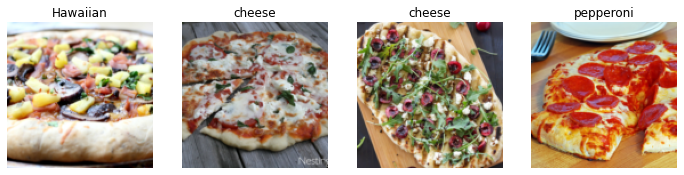

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

# Item Transformations 


## Format 
1. Make new DataBlock w/ the Transformation 
2. Load the DataBlock 


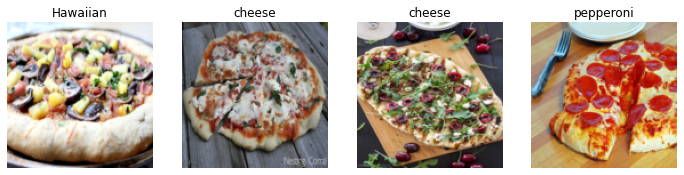

In [13]:
# Squish Method 
pizzas = pizzas.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pizzas.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

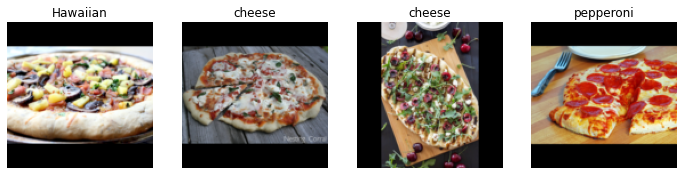

In [14]:
# Pad method 
pizzas = pizzas.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = pizzas.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

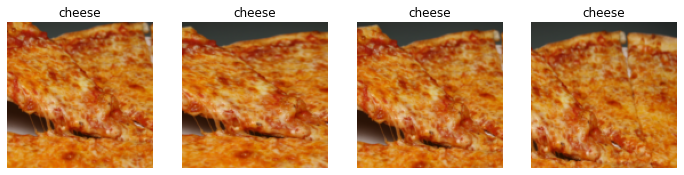

In [15]:
# Random Resized Crop
pizzas = pizzas.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pizzas.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augmentation


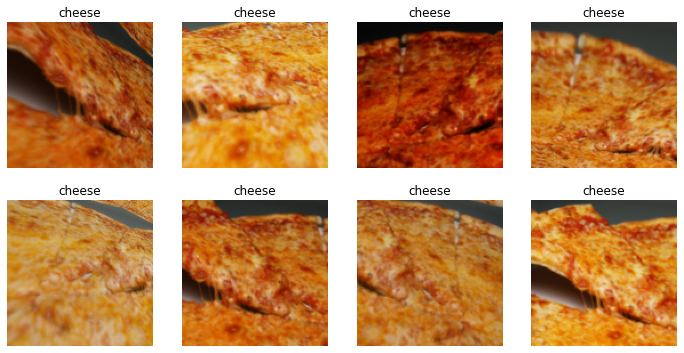

In [16]:
pizzas = pizzas.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pizzas.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train Our Model and Use It for Data Cleaning 

In [18]:
pizzas = pizzas.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pizzas.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.808467,1.279251,0.460000,00:25


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.118671,0.924386,0.380000,00:25
1,0.966500,0.780762,0.240000,00:25
2,0.796653,0.685537,0.210000,00:26
3,0.697854,0.659016,0.200000,00:25


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

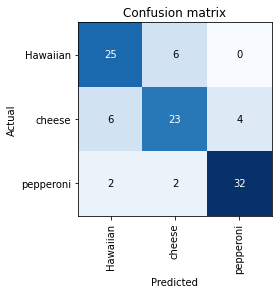

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

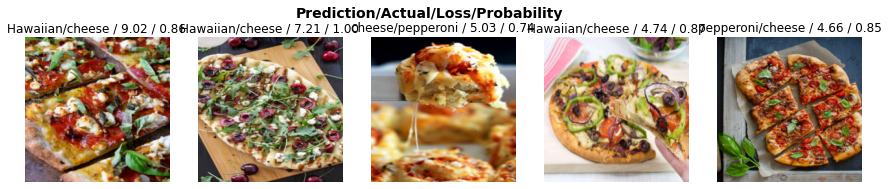

In [21]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner